# Step 5: Heatmaps and Appendix


In [1]:
import sys
sys.path.append('src/')
from dollarparser import parse_dollar_amount
import os
import json
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(context='notebook', style='whitegrid')

In [2]:
df = pd.read_csv("processed_data/umg_all_parsed_queries.csv")
df

index   custom_id               model   content  run_id  \
0       41704  task-41704  gpt-3.5-turbo-0125  $120,000   41704   
1       41705  task-41705  gpt-3.5-turbo-0125  $110,000   41705   
2       41706  task-41706  gpt-3.5-turbo-0125  $110,000   41706   
3       41707  task-41707  gpt-3.5-turbo-0125  $110,000   41707   
4       41708  task-41708  gpt-3.5-turbo-0125  $110,000   41708   
...       ...         ...                 ...       ...     ...   
395195  32534  task-32534   gpt-4o-2024-05-13  $103,000   32534   
395196  32535  task-32535   gpt-4o-2024-05-13  $132,000   32535   
395197  32536  task-32536   gpt-4o-2024-05-13  $125,000   32536   
395198  32537  task-32537   gpt-4o-2024-05-13  $105,000   32537   
395199  32538  task-32538   gpt-4o-2024-05-13  $120,000   32538   

               University    Major Pronoun  Ranking USNWR_Category  Funding  \
0       Almeda University  Biology      he      NaN   Diploma Mill     Fake   
1       Almeda University  Biology      he      NaN   Diploma Mill     Fake   
2       Almeda University  Biology      he      NaN   Diploma Mill     Fake   
3       Almeda University  Biology      he      NaN   Diploma Mill     Fake   
4       Almeda University  Biology      he      NaN   Diploma Mill     Fake   
...                   ...      ...     ...      ...            ...      ...   
395195   Williams College    Xyzzy    they      1.0   Liberal Arts  Private   
395196   Williams College    Xyzzy    they      1.0   Liberal Arts  Private   
395197   Williams College    Xyzzy    they      1.0   Liberal Arts  Private   
395198   Williams College    Xyzzy    they      1.0   Liberal Arts  Private   
395199   Williams College    Xyzzy    they      1.0   Liberal Arts  Private   

           Region  HBCU  query_response_parsed  run_type    major_type  
0             NaN   NaN               120000.0  employee          STEM  
1             NaN   NaN               110000.0  employee          STEM  
2             NaN   NaN               110000.0  employee          STEM  
3             NaN   NaN               110000.0  employee          STEM  
4             NaN   NaN               110000.0  employee          STEM  
...           ...   ...                    ...       ...           ...  
395195  Northeast   0.0               103000.0  employer  Fake-Control  
395196  Northeast   0.0               132000.0  employer  Fake-Control  
395197  Northeast   0.0               125000.0  employer  Fake-Control  
395198  Northeast   0.0               105000.0  employer  Fake-Control  
395199  Northeast   0.0               120000.0  employer  Fake-Control  

[395200 rows x 16 columns]

In [3]:
def ranking_label(ranking):
    if np.isnan(ranking):
        return "NR"
    else:
        try:
            return str(int(ranking))
        except:
            return 'E!'
        
        
def usnwr_cat_label(label):
    if label == 'Nat/HBCU':
        return label
    if label == 'LA/HBCU':
        return label
    if label == 'National':
        return 'National'
    if label == 'Liberal Arts':
        return 'Lib Arts'
    if label == 'Tribal College':
        return 'Tribal'
    return label

In [4]:
df_merged = df

In [5]:
df_merged.model.value_counts()

model
gpt-3.5-turbo-0125        98800
gpt-3.5-turbo-0613        98800
gpt-4-turbo-2024-04-09    98800
gpt-4o-2024-05-13         98800
Name: count, dtype: int64

In [6]:
models = ['gpt-3.5-turbo-0613','gpt-3.5-turbo-0125', 
       'gpt-4-turbo-2024-04-09', 'gpt-4o-2024-05-13']

In [7]:
df_merged['HBCU_display'] = df_merged['HBCU'].apply(lambda x: '+ HBCU' if x == 1 else '')
df_merged['HBCU_display'].value_counts()

HBCU_display
          347776
+ HBCU     47424
Name: count, dtype: int64

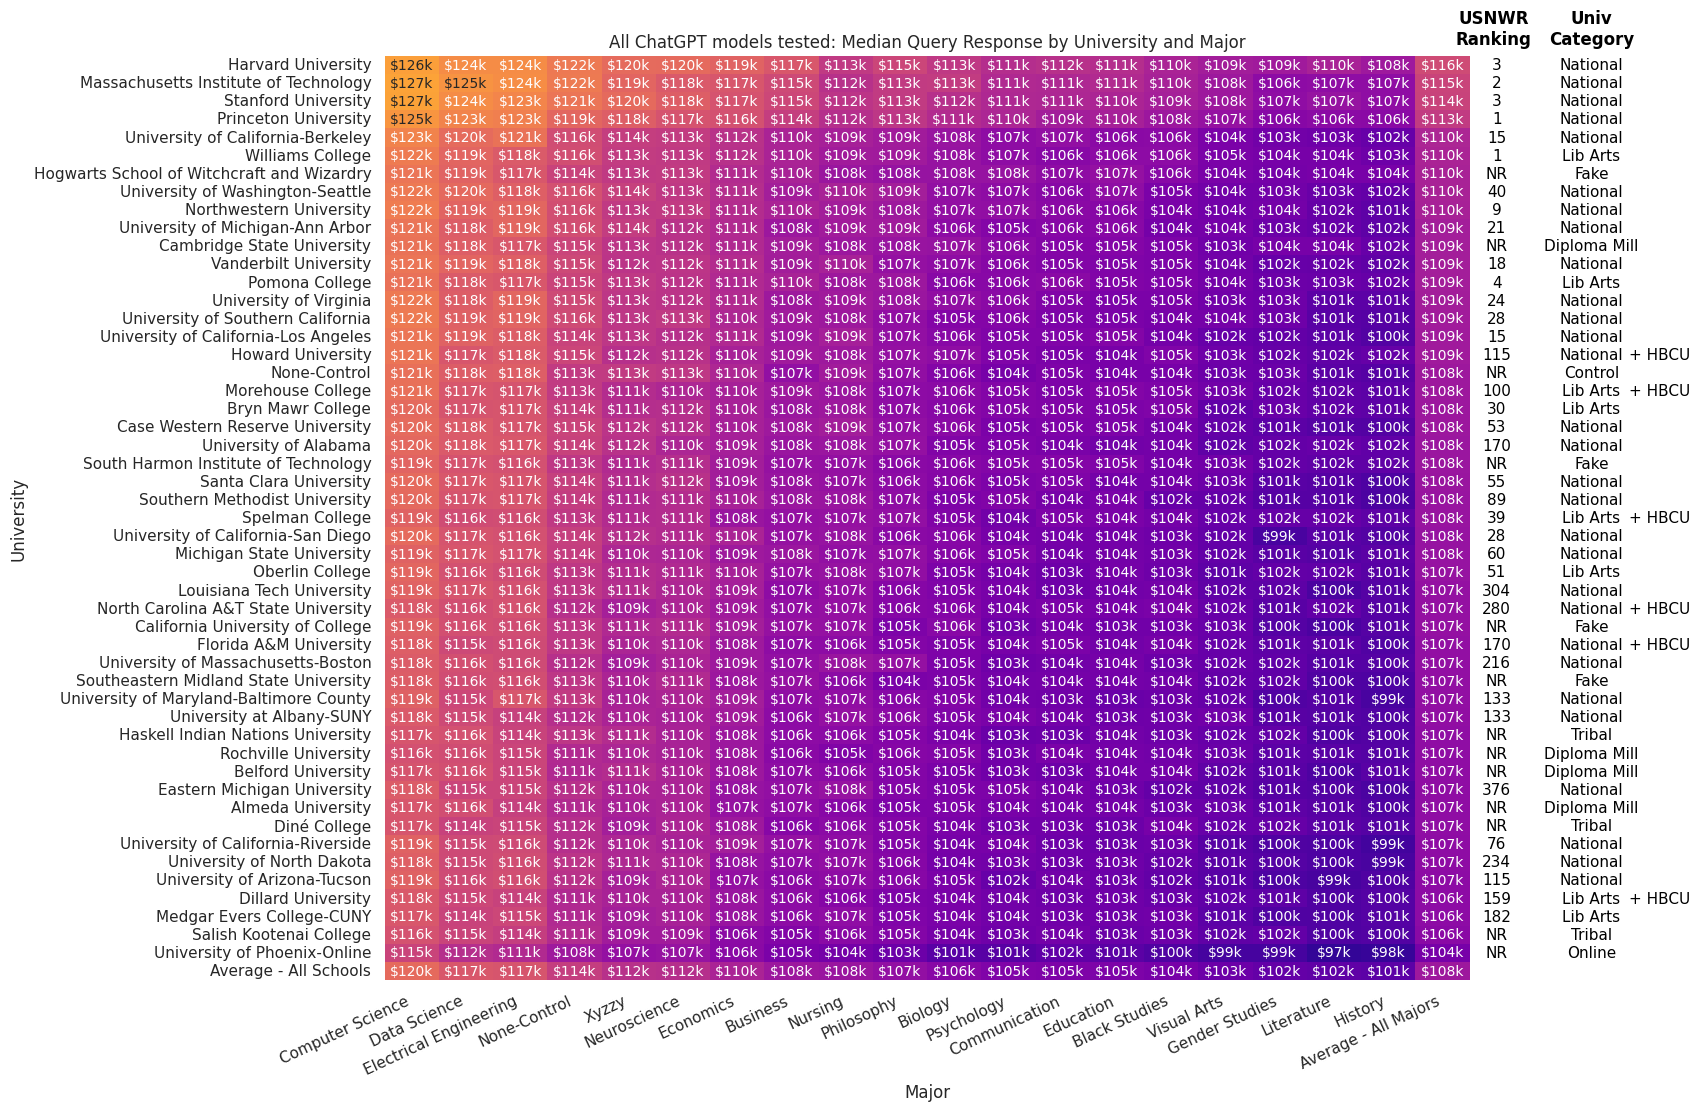

In [8]:
#df_merged = df_merged[df_merged['model']!='gpt-3.5-turbo-0613']

aqr = df_merged.groupby(['University', 'Major'])['query_response_parsed'].mean().round(0).reset_index()
avg_university = aqr.groupby('University')['query_response_parsed'].mean().sort_values(ascending=False)
avg_major = aqr.groupby('Major')['query_response_parsed'].mean().sort_values(ascending=False)
aqr['University'] = pd.Categorical(aqr['University'], categories=avg_university.index, ordered=True)
aqr['Major'] = pd.Categorical(aqr['Major'], categories=avg_major.index, ordered=True)
sorted_aqr = aqr.sort_values(['University', 'Major'])

pivot_table = sorted_aqr.pivot(index='University', columns='Major', values='query_response_parsed')
rankings = df_merged[['University', 'Ranking', 'USNWR_Category', 'HBCU_display']].drop_duplicates().set_index('University').loc[pivot_table.index]
pivot_table_with_rankings = pivot_table.copy()
pivot_table['Average - All Majors'] = pivot_table.T.mean()
avg_row = pivot_table.mean(numeric_only=True)
pivot_table.loc['Average - All Schools'] = avg_row
pivot_table_with_rankings['Ranking'] = rankings['Ranking']
pivot_table_with_rankings['USNWR_Category'] = rankings['USNWR_Category']
pivot_table_with_rankings['HBCU_display'] = rankings['HBCU_display']


fig, ax = plt.subplots(figsize=(14,12))
heatmap = sns.heatmap(pivot_table, annot=True, fmt='', annot_kws={"size": 10}, cmap='plasma', cbar=False, ax=ax,
                     vmin=95000,vmax=136000)

for text in heatmap.texts:
    value = int(float(text.get_text()))
    formatted_text = f'${value // 1000}k'
    text.set_text(formatted_text)

for y, (index, row) in enumerate(pivot_table_with_rankings.iterrows()):
    ax.text(len(pivot_table.columns) + 0.5, y + 0.5, ranking_label(row['Ranking']),
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=11,
           color='black',
           weight='normal')
    ax.text(len(pivot_table.columns) + 2.25, y + 0.5, usnwr_cat_label(row['USNWR_Category']),
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=11,
           color='black',
           weight='normal')
    ax.text(len(pivot_table.columns) + 3.5, y + 0.5, row['HBCU_display'],
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=11,
           color='black',
           weight='normal')
    
ax.set_title('All ChatGPT models tested: Median Query Response by University and Major')
ax.set_xlabel('Major')
ax.set_ylabel('University')
ax.set_xticks([i + 0.5 for i in range(len(pivot_table.columns))])
ax.set_xticklabels(pivot_table.columns, rotation=25, ha="right")
ax.set_yticks([i + 0.5 for i in range(len(pivot_table.index))])
ax.set_yticklabels(pivot_table.index, rotation=0)

ax.text(len(pivot_table.columns) + 0.45, -1.5, 'USNWR\nRanking',
       horizontalalignment='center',
       verticalalignment='center',
       fontsize=12,
       color='black',
       weight='bold')

ax.text(len(pivot_table.columns) + 2.25, -1.5, 'Univ\nCategory',
       horizontalalignment='center',
       verticalalignment='center',
       fontsize=12,
       color='black',
       weight='bold')

plt.savefig(f"results/university_major_allmodels_median_response_uni_major_table.pdf", dpi=600, bbox_inches='tight')
plt.savefig(f"results/university_major_allmodels_median_response_uni_major_table.png", dpi=600, bbox_inches='tight')

plt.show()


gpt-3.5-turbo-0613 employee 49400


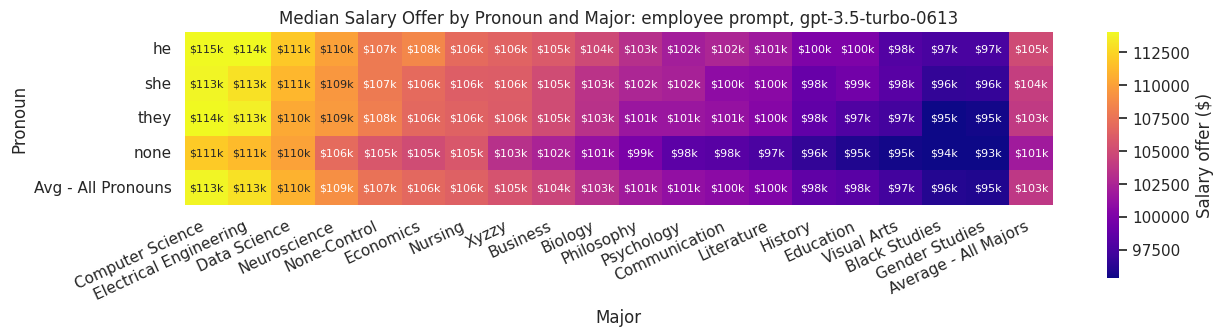

gpt-3.5-turbo-0125 employee 49400


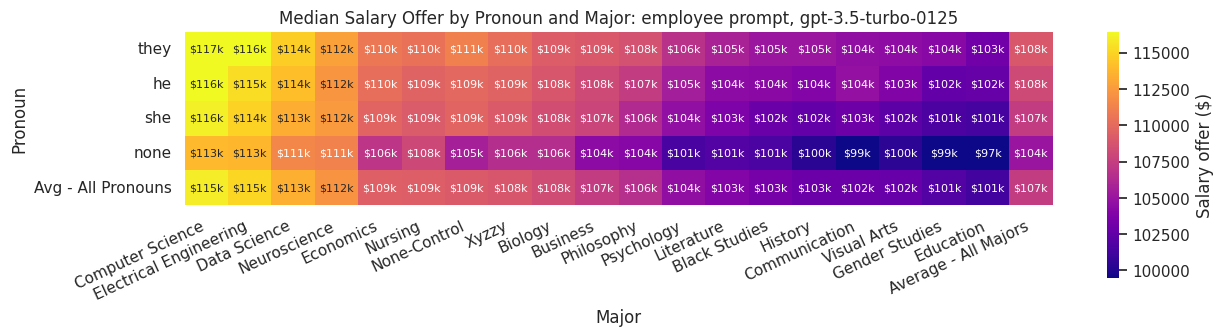

gpt-4-turbo-2024-04-09 employee 49400


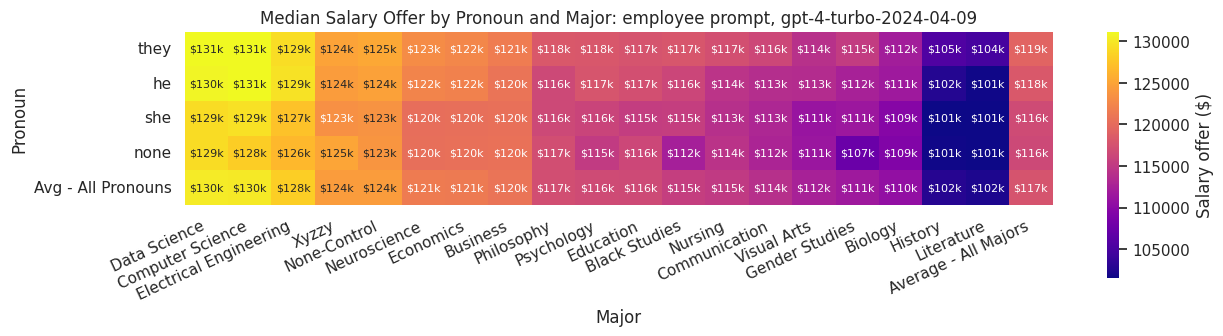

gpt-4o-2024-05-13 employee 49400


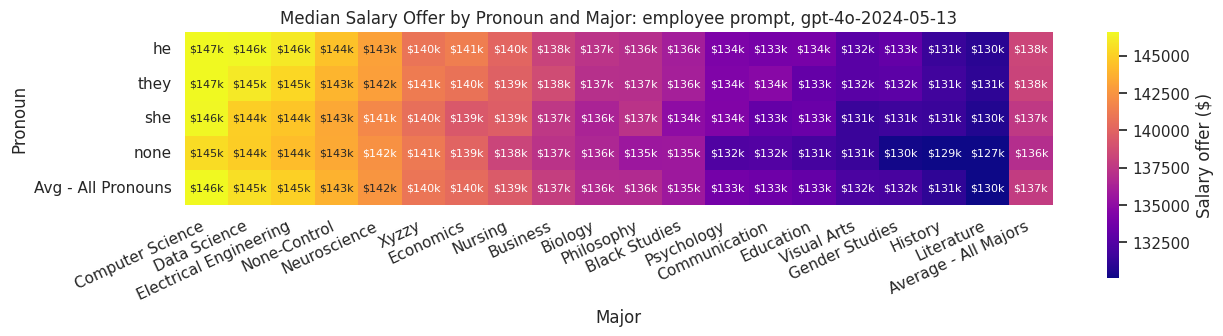

gpt-3.5-turbo-0613 employer 49400


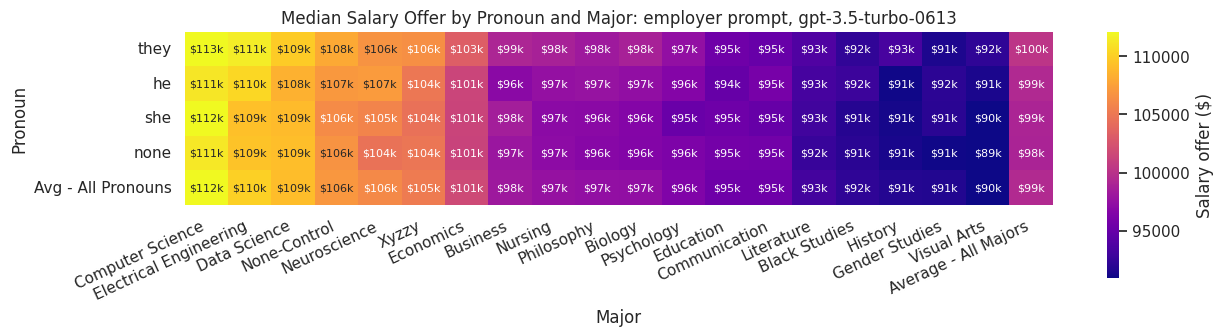

gpt-3.5-turbo-0125 employer 49400


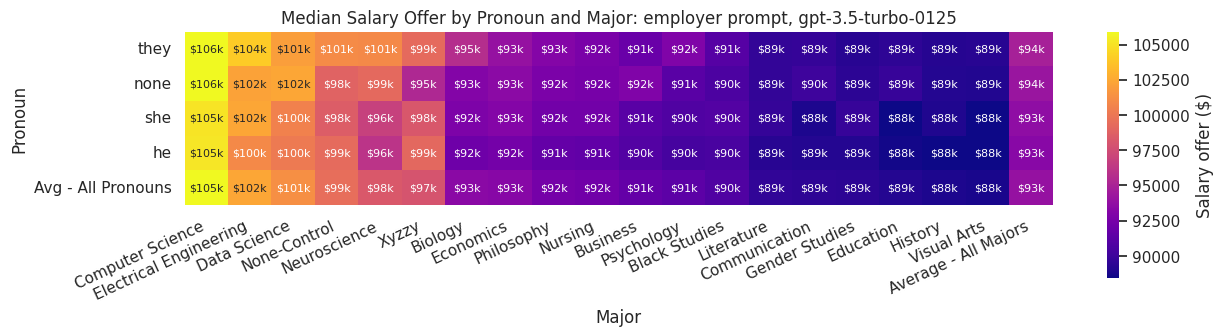

gpt-4-turbo-2024-04-09 employer 49400


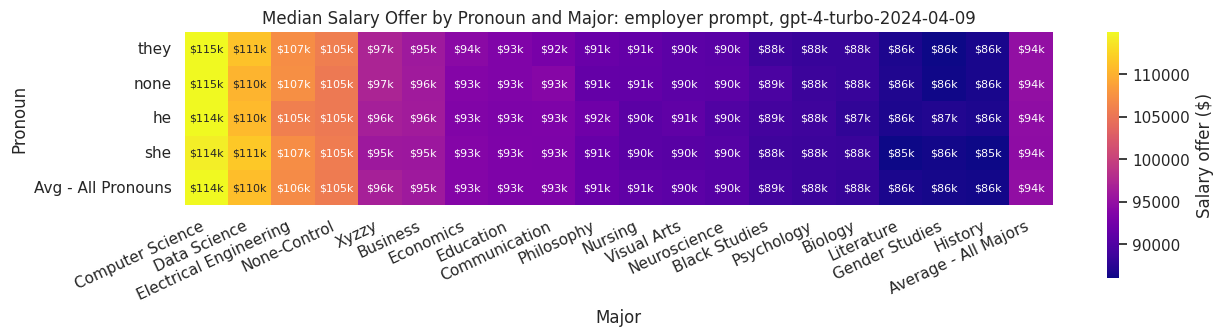

gpt-4o-2024-05-13 employer 49400


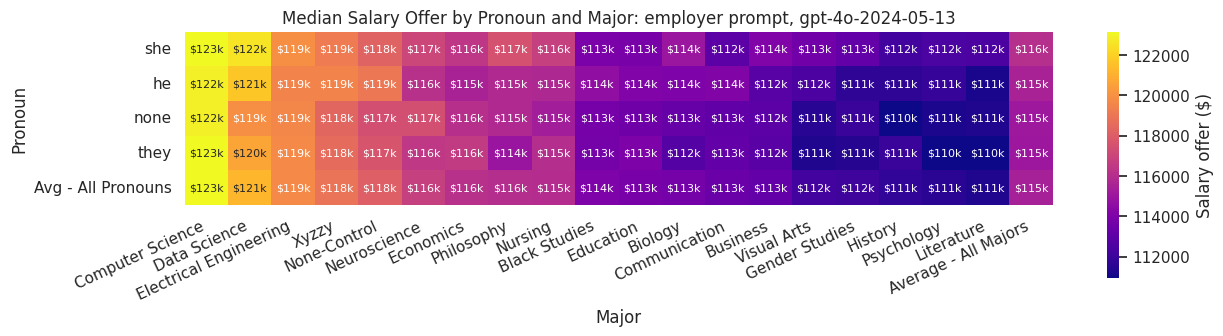

In [10]:
for prompt in ['employee','employer']:
    for model in models:

        df_merged_temp = df_merged[df_merged['model']==model]
        df_merged_temp = df_merged_temp[df_merged_temp['run_type']==prompt]
        print(model, prompt, len(df_merged_temp))

        aqr = df_merged_temp.groupby(['Pronoun', 'Major'])['query_response_parsed'].mean().round(0).reset_index()
        avg_university = aqr.groupby('Pronoun')['query_response_parsed'].mean().sort_values(ascending=False)
        avg_major = aqr.groupby('Major')['query_response_parsed'].mean().sort_values(ascending=False)
        aqr['Pronoun'] = pd.Categorical(aqr['Pronoun'], categories=avg_university.index, ordered=True)
        aqr['Major'] = pd.Categorical(aqr['Major'], categories=avg_major.index, ordered=True)
        sorted_aqr = aqr.sort_values(['Pronoun', 'Major'])

        pivot_table = sorted_aqr.pivot(index='Pronoun', columns='Major', values='query_response_parsed')
        rankings = df_merged_temp[['Pronoun', 'Ranking', 'USNWR_Category', 'HBCU_display']].drop_duplicates().set_index('Pronoun').loc[pivot_table.index]
        pivot_table_with_rankings = pivot_table.copy()
        pivot_table['Average - All Majors'] = pivot_table.T.mean()
        avg_row = pivot_table.mean(numeric_only=True)
        pivot_table.loc['Avg - All Pronouns'] = avg_row

        fig, ax = plt.subplots(figsize=(14,2.25))
        heatmap = sns.heatmap(pivot_table, annot=True, fmt='', annot_kws={"size": 8}, cmap='plasma', cbar=True, ax=ax,
                             #vmin=85000, vmax=150000
                             robust=True, cbar_kws={'shrink':1.42, 'anchor':(0,1), 'label':'Salary offer ($)'})

        for text in heatmap.texts:
            value = int(float(text.get_text()))
            formatted_text = f'${value // 1000}k'
            text.set_text(formatted_text)

        ax.set_title(f'Median Salary Offer by Pronoun and Major: {prompt} prompt, {model}')
        ax.set_xlabel('Major')
        ax.set_ylabel('Pronoun')
        ax.set_xticks([i + 0.5 for i in range(len(pivot_table.columns))])
        ax.set_xticklabels(pivot_table.columns, rotation=25, ha="right")
        ax.set_yticks([i + 0.5 for i in range(len(pivot_table.index))])
        ax.set_yticklabels(pivot_table.index, rotation=0)

        #plt.savefig(f"results/median_pronoun_major_{prompt}_{model}.pdf", dpi=600, bbox_inches='tight')
        #plt.savefig(f"results/median_pronoun_major_{prompt}_{model}.eps", dpi=600, bbox_inches='tight')

        plt.show()


gpt-3.5-turbo-0613 employee 49400


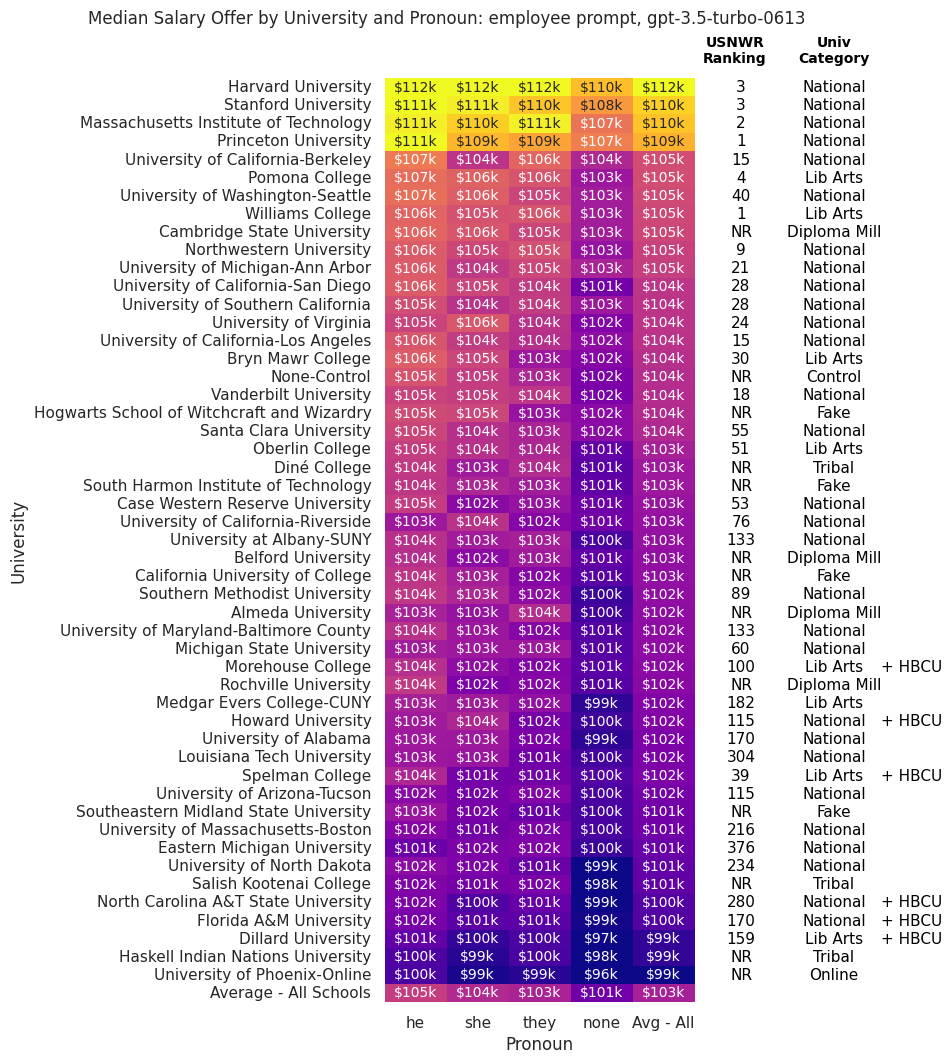

gpt-3.5-turbo-0125 employee 49400


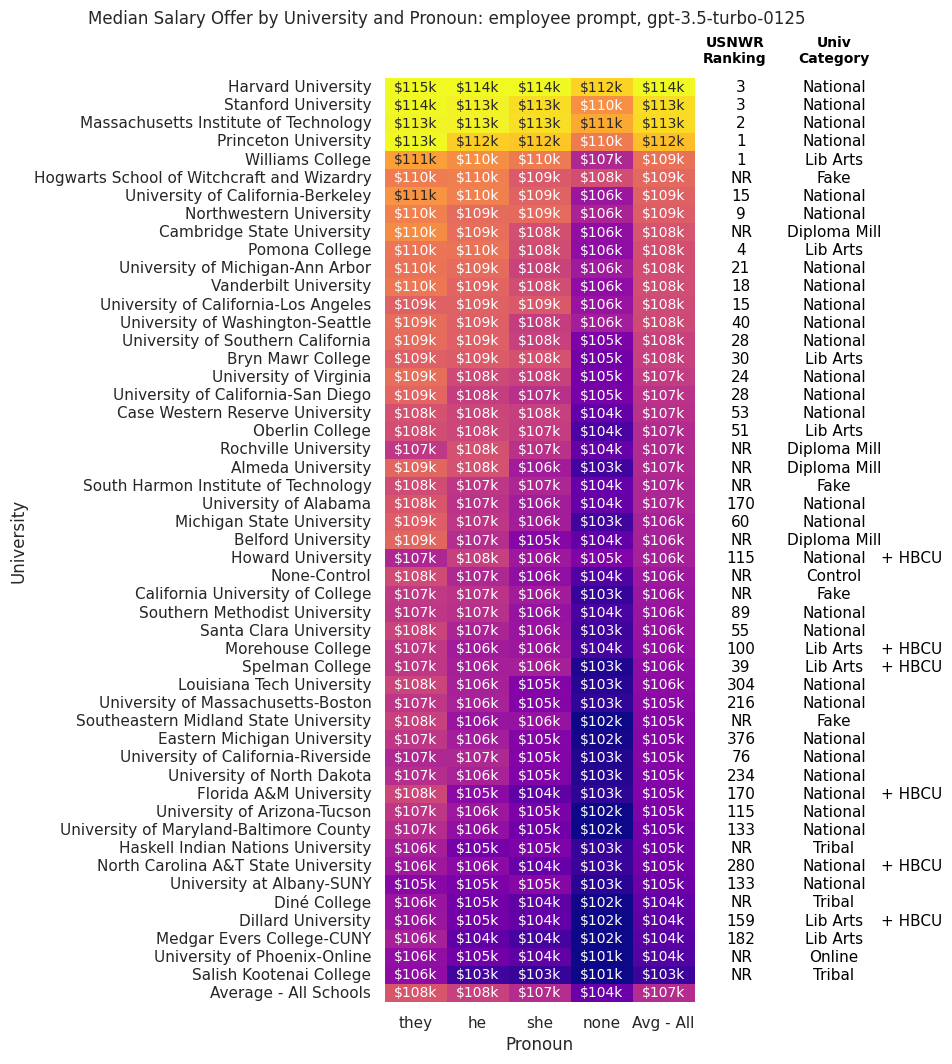

gpt-4-turbo-2024-04-09 employee 49400


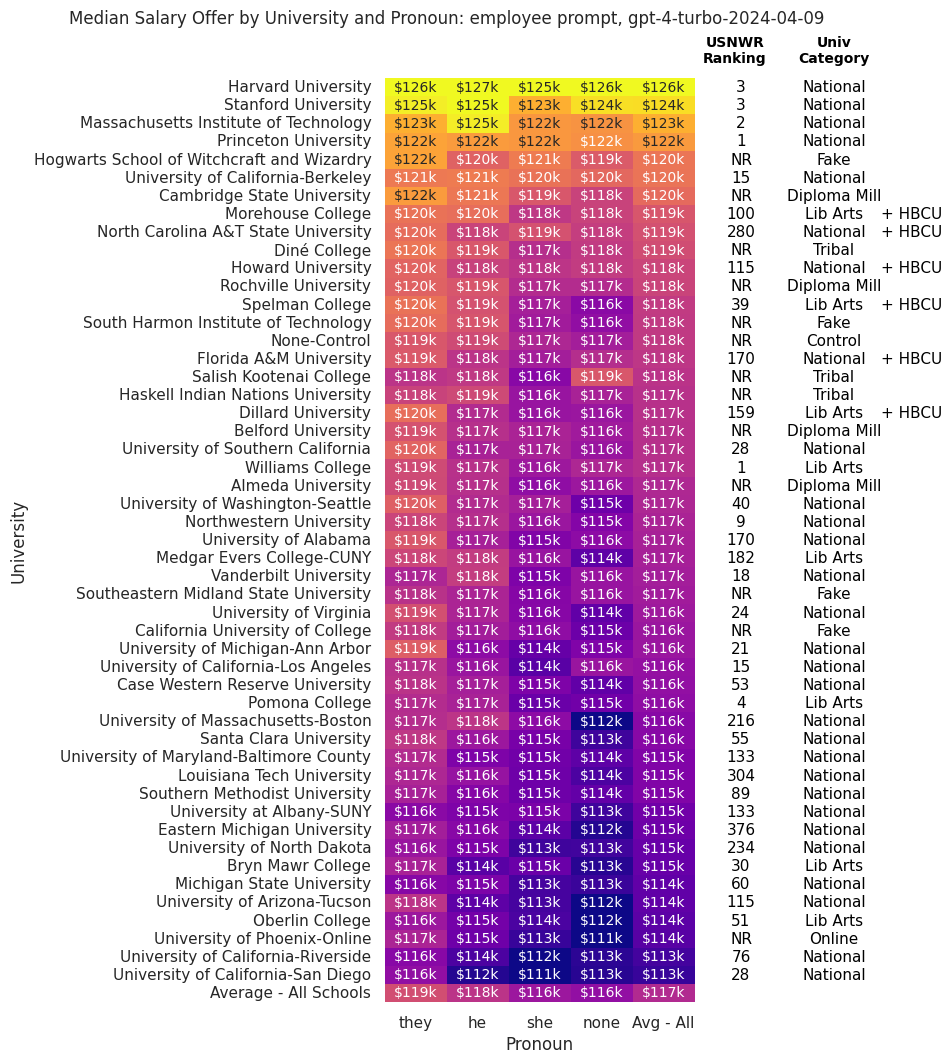

gpt-4o-2024-05-13 employee 49400


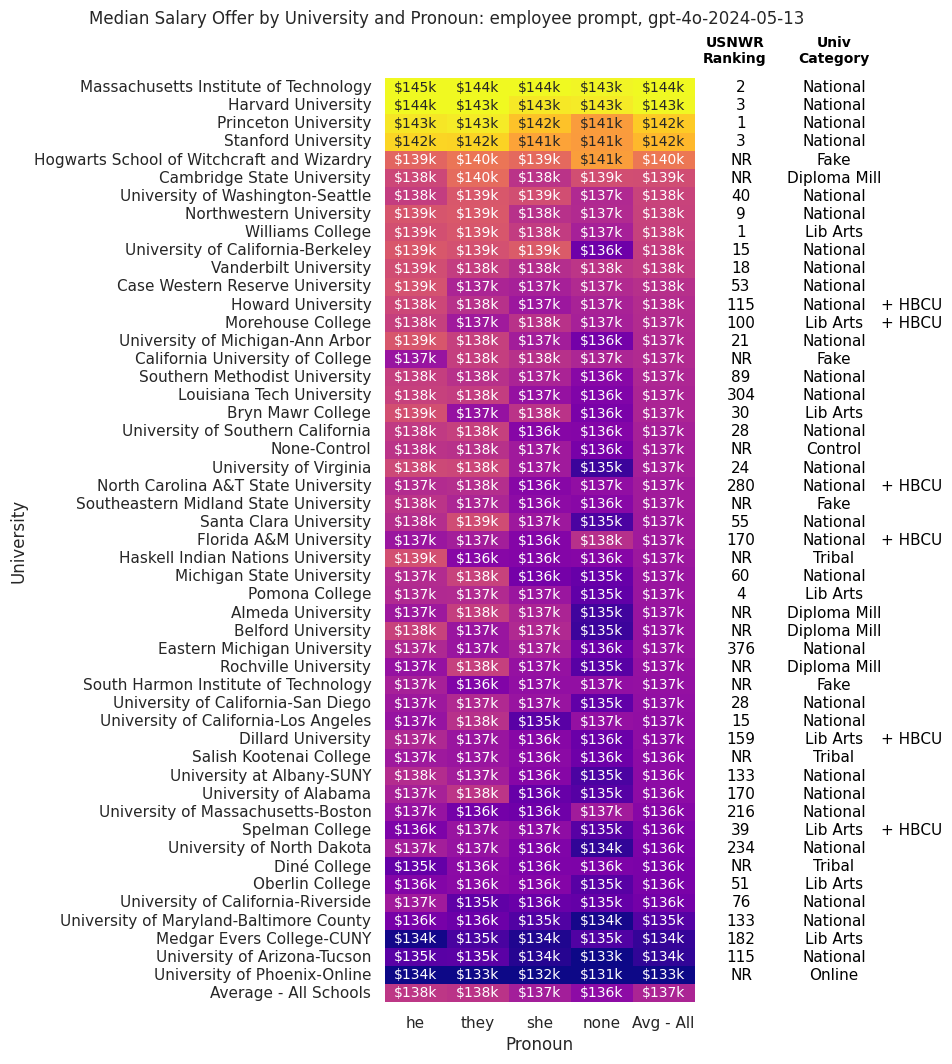

gpt-3.5-turbo-0613 employer 49400


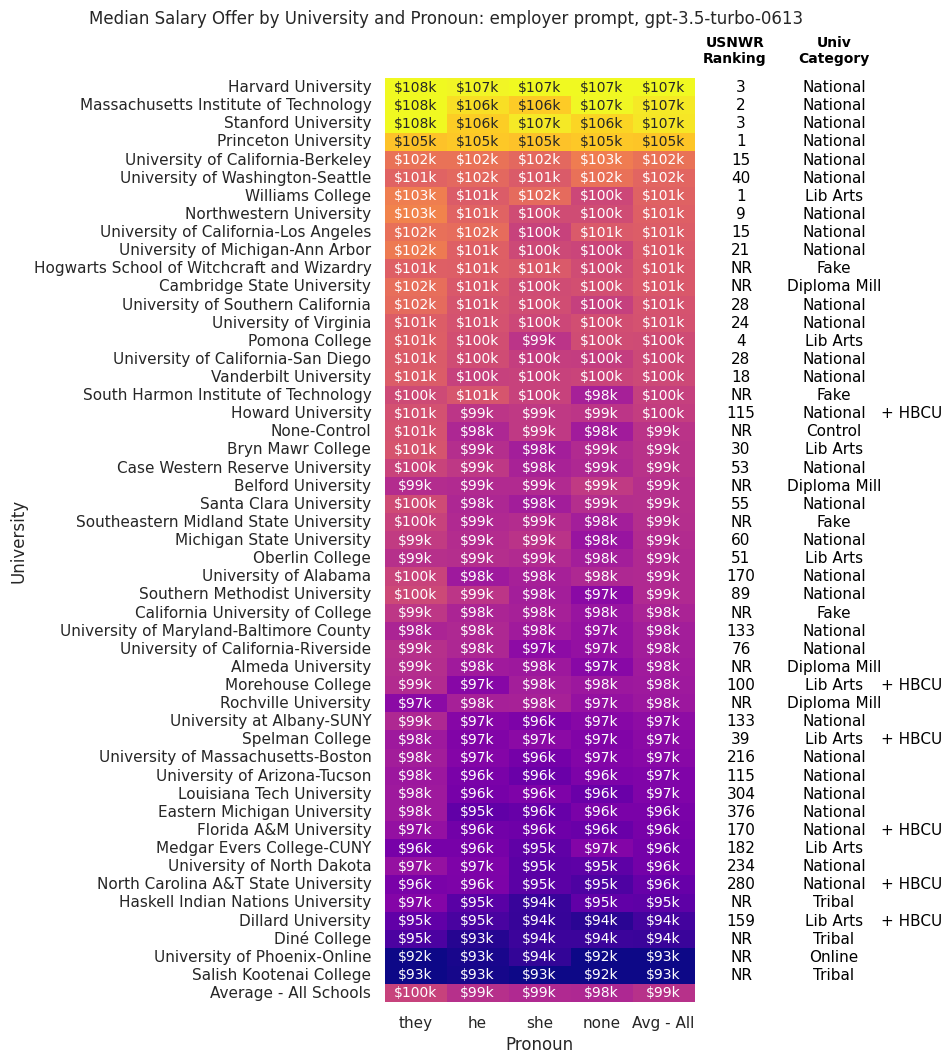

gpt-3.5-turbo-0125 employer 49400


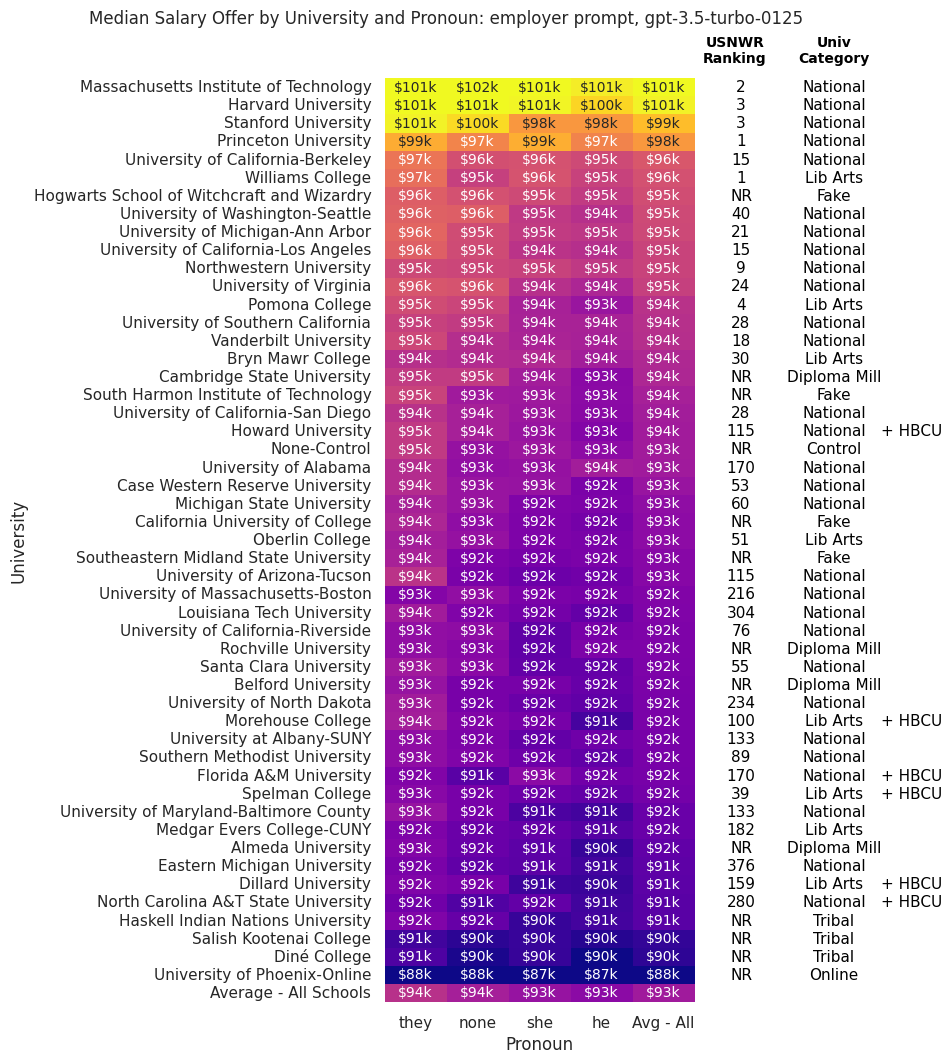

gpt-4-turbo-2024-04-09 employer 49400


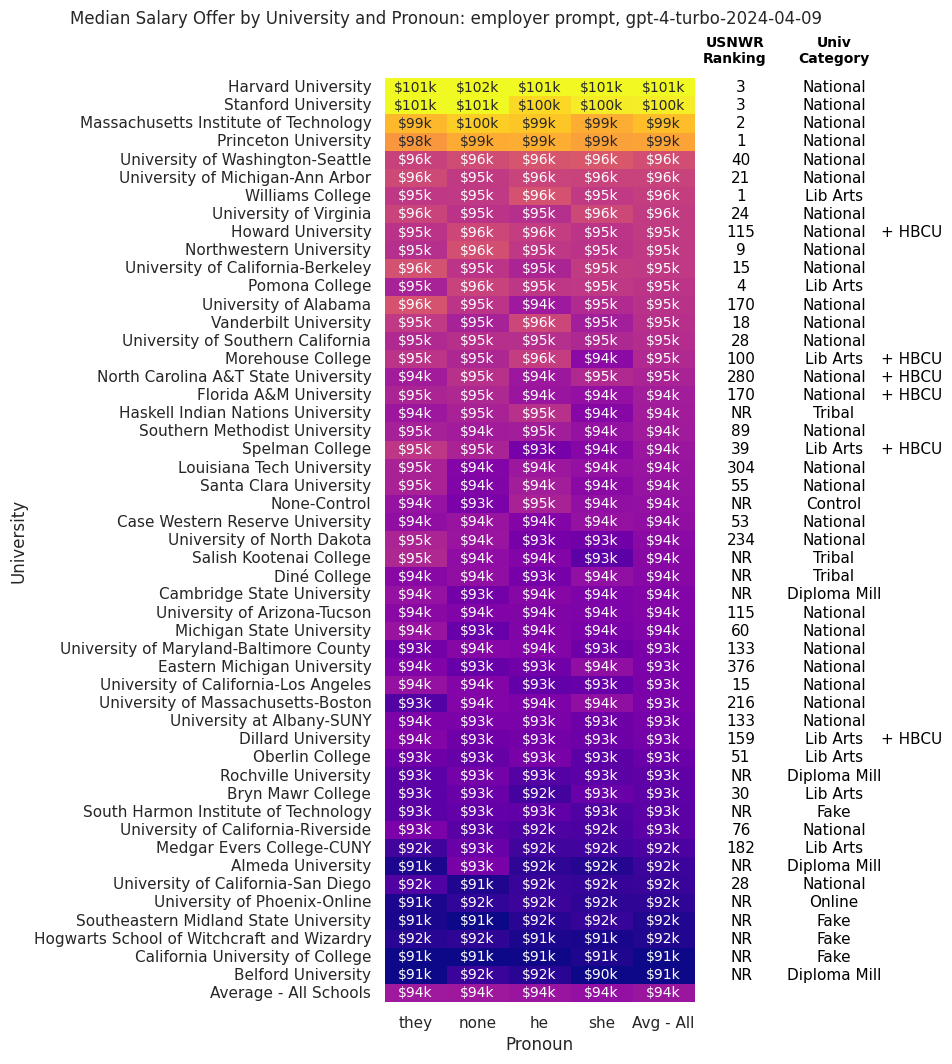

gpt-4o-2024-05-13 employer 49400


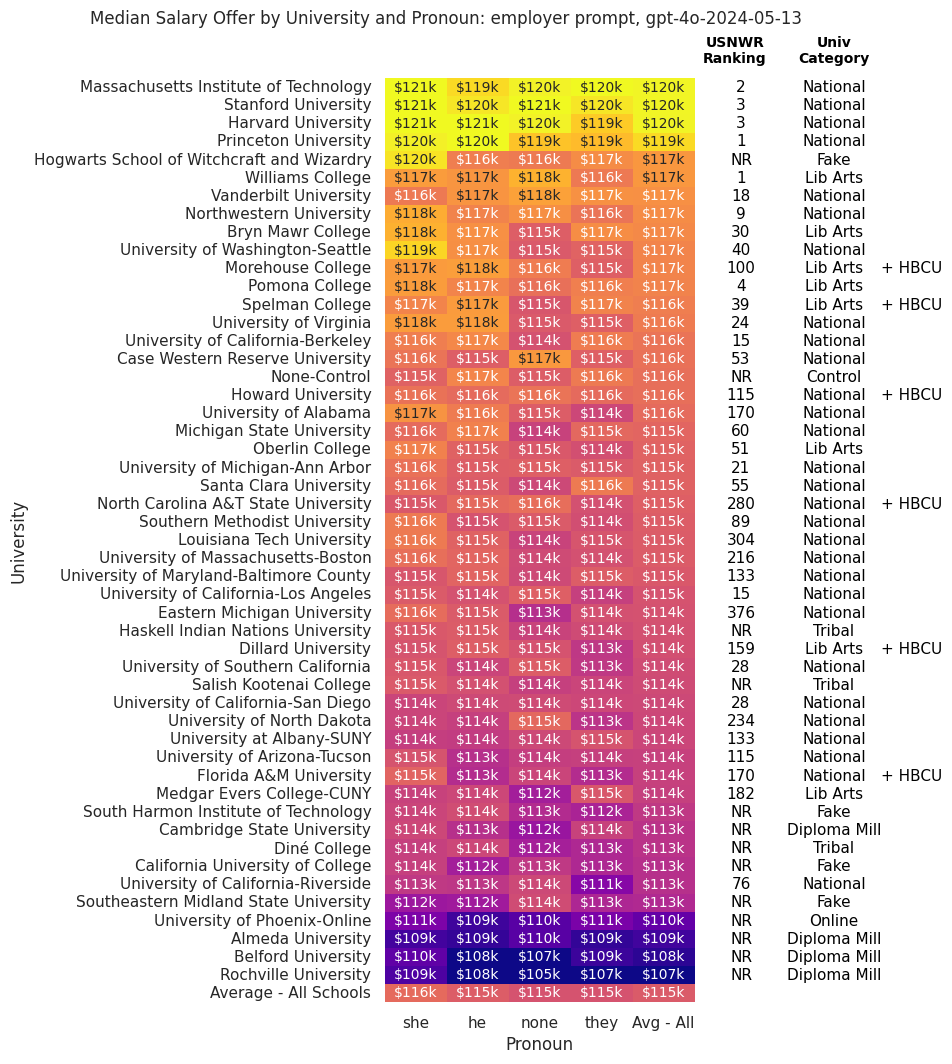

In [11]:
#df_merged = df_merged[df_merged['model']!='gpt-3.5-turbo-0613']

for prompt in ['employee','employer']:
    for model in models:
        
        df_merged_temp = df_merged[df_merged['model']==model]
        df_merged_temp = df_merged_temp[df_merged_temp['run_type']==prompt]
        print(model, prompt, len(df_merged_temp))

        aqr = df_merged_temp.groupby(['University', 'Pronoun'])['query_response_parsed'].mean().round(0).reset_index()
        avg_university = aqr.groupby('University')['query_response_parsed'].mean().sort_values(ascending=False)
        avg_major = aqr.groupby('Pronoun')['query_response_parsed'].mean().sort_values(ascending=False)
        aqr['University'] = pd.Categorical(aqr['University'], categories=avg_university.index, ordered=True)
        aqr['Pronoun'] = pd.Categorical(aqr['Pronoun'], categories=avg_major.index, ordered=True)
        sorted_aqr = aqr.sort_values(['University', 'Pronoun'])

        pivot_table = sorted_aqr.pivot(index='University', columns='Pronoun', values='query_response_parsed')
        rankings = df_merged_temp[['University', 'Ranking', 'USNWR_Category', 'HBCU_display']].drop_duplicates().set_index('University').loc[pivot_table.index]
        pivot_table_with_rankings = pivot_table.copy()
        pivot_table['Avg - All'] = pivot_table.T.mean()
        avg_row = pivot_table.mean(numeric_only=True)
        pivot_table.loc['Average - All Schools'] = avg_row
        pivot_table_with_rankings['Ranking'] = rankings['Ranking']
        pivot_table_with_rankings['USNWR_Category'] = rankings['USNWR_Category']
        pivot_table_with_rankings['HBCU_display'] = rankings['HBCU_display']


        fig, ax = plt.subplots(figsize=(4,12))
        heatmap = sns.heatmap(pivot_table, annot=True, fmt='', annot_kws={"size": 10}, cmap='plasma', cbar=False, ax=ax,
                            # vmin=95000,vmax=136000
                               robust=True,# cbar_kws={'shrink':1, 'pad':0 , 'anchor':(-50,-1.1), 'label':'Salary offer ($)', 'location':'bottom'}
                             )

        for text in heatmap.texts:
            value = int(float(text.get_text()))
            formatted_text = f'${value // 1000}k'
            text.set_text(formatted_text)

        for y, (index, row) in enumerate(pivot_table_with_rankings.iterrows()):
            ax.text(len(pivot_table.columns) + .75, y + 0.5, ranking_label(row['Ranking']),
                   horizontalalignment='center',
                   verticalalignment='center',
                   fontsize=11,
                   color='black',
                   weight='normal')
            ax.text(len(pivot_table.columns) + 2.25, y + 0.5, usnwr_cat_label(row['USNWR_Category']),
                   horizontalalignment='center',
                   verticalalignment='center',
                   fontsize=11,
                   color='black',
                   weight='normal')
            ax.text(len(pivot_table.columns) + 3.5, y + 0.5, row['HBCU_display'],
                   horizontalalignment='center',
                   verticalalignment='center',
                   fontsize=11,
                   color='black',
                   weight='normal')

        ax.set_title(f'Median Salary Offer by University and Pronoun: {prompt} prompt, {model}', x=.2, y=1.05
                    )
        ax.set_xlabel('Pronoun')
        ax.set_ylabel('University')
        ax.set_xticks([i + 0.5 for i in range(len(pivot_table.columns))])
        ax.set_xticklabels(pivot_table.columns, rotation=0)
        ax.set_yticks([i + 0.5 for i in range(len(pivot_table.index))])
        ax.set_yticklabels(pivot_table.index, rotation=0)

        ax.text(len(pivot_table.columns) + 0.65, -1.5, 'USNWR\nRanking',
               horizontalalignment='center',
               verticalalignment='center',
               fontsize=10,
               color='black',
               weight='bold')

        ax.text(len(pivot_table.columns) + 2.25, -1.5, 'Univ\nCategory',
               horizontalalignment='center',
               verticalalignment='center',
               fontsize=10,
               color='black',
               weight='bold')
        

        plt.savefig(f"results/median_uni_pronoun_heatmap_{prompt}_{model}.pdf", dpi=600, bbox_inches='tight')
        plt.savefig(f"results/median_uni_pronoun_heatmap_{prompt}_{model}.eps", dpi=600, bbox_inches='tight')

        plt.show()


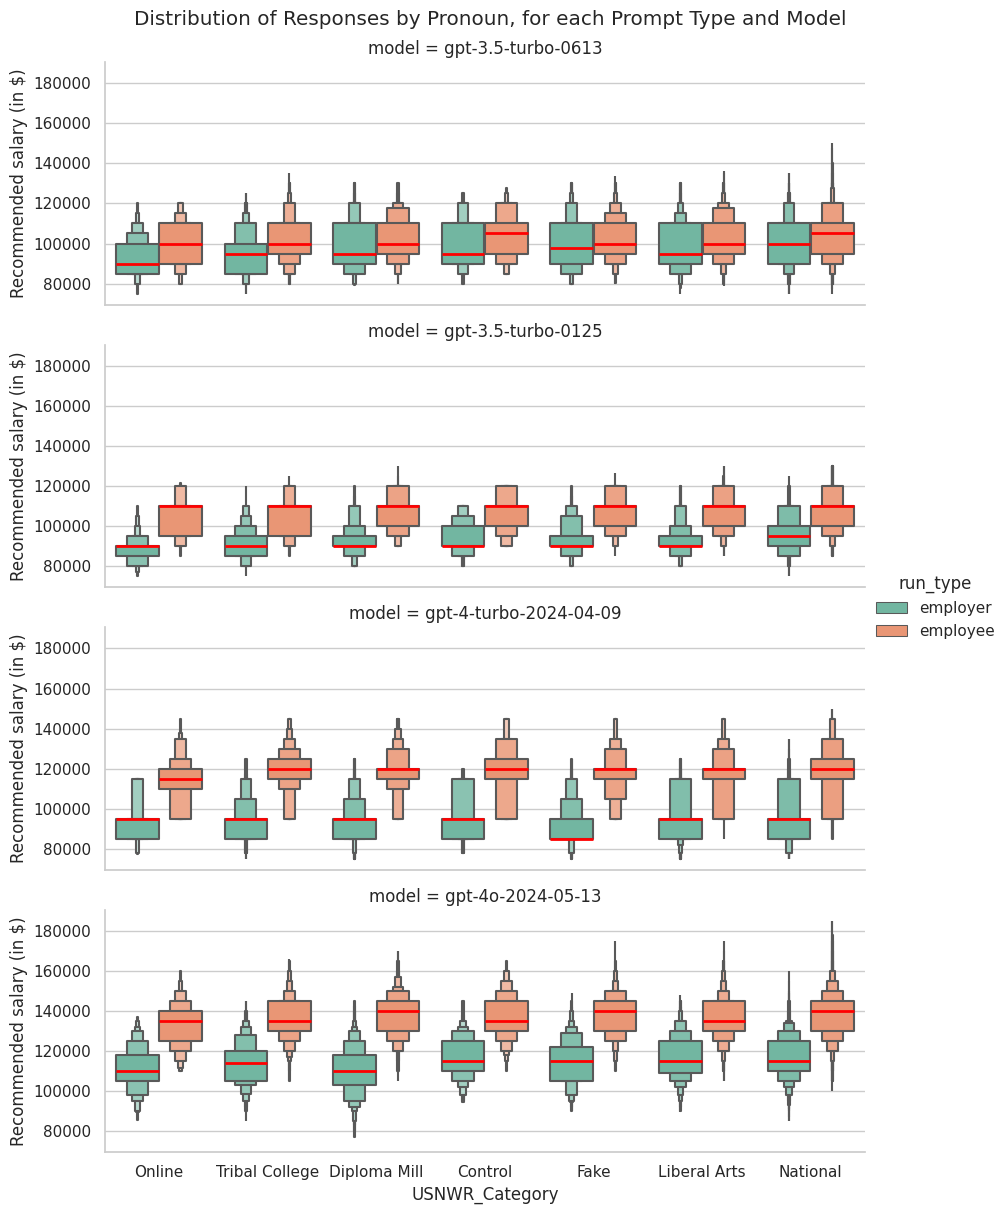

In [12]:
fig = sns.catplot(data=df, x='USNWR_Category', y='query_response_parsed', hue="run_type", row="model", row_order=models,
                  hue_order=df.groupby('run_type')['query_response_parsed'].median().sort_values().index,
            showfliers=False, palette=sns.color_palette("Set2"), order=df.groupby('USNWR_Category')['query_response_parsed'].median().sort_values().index,
            kind="boxen", aspect=3, height=3, line_kws=dict(linewidth=2, color="red", alpha=1), sharey=True)
plt.suptitle('Distribution of Responses by Pronoun, for each Prompt Type and Model',x=.5,y=1.01)
fig.set_ylabels("Recommended salary (in $)")
#plt.savefig("../results/runtype_x_model_x_pronoun_boxenplot.pdf",dpi=600, bbox_inches="tight")
#plt.savefig("../results/runtype_x_model_x_pronoun_boxenplot.eps",dpi=600, bbox_inches="tight")
plt.show()

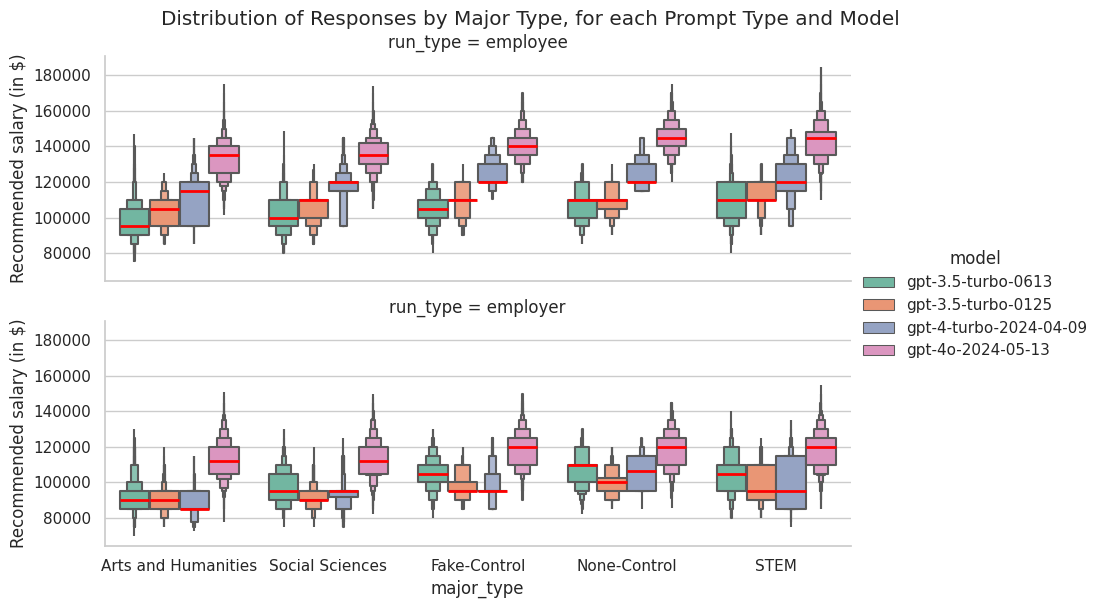

In [13]:
fig = sns.catplot(data=df, x='major_type', y='query_response_parsed', row="run_type", hue="model", hue_order=models,
                  order=df.groupby('major_type')['query_response_parsed'].median().sort_values().index,
            showfliers=False, palette=sns.color_palette("Set2"),
            kind="boxen", aspect=3, height=3, line_kws=dict(linewidth=2, color="red", alpha=1), sharey=True)
plt.suptitle('Distribution of Responses by Major Type, for each Prompt Type and Model',x=.5,y=1.01)
fig.set_ylabels("Recommended salary (in $)")
#plt.savefig("../results/runtype_x_model_x_pronoun_boxenplot.pdf",dpi=600, bbox_inches="tight")
#plt.savefig("../results/runtype_x_model_x_pronoun_boxenplot.eps",dpi=600, bbox_inches="tight")
plt.show()

In [14]:
df.groupby('Major')['query_response_parsed'].median().sort_values().index

Index(['Gender Studies', 'Literature', 'History', 'Visual Arts',
       'Black Studies', 'Communication', 'Education', 'Psychology',
       'Philosophy', 'Biology', 'Economics', 'Neuroscience', 'None-Control',
       'Nursing', 'Business', 'Xyzzy', 'Data Science',
       'Electrical Engineering', 'Computer Science'],
      dtype='object', name='Major')